# Colorado Motor Vehicle Sales Data Analysis

### Objective
To analyze Colorado motor vehicle sales data to:
- Identify sales trends over years and quarters
- Compare sales across counties
- Explore seasonal patterns
- Forecast future sales using statistical and machine learning models

# Importing the Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import ipywidgets as widgets

%matplotlib inline
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

# Data Overview

In [2]:
df = pd.read_csv("colorado_motor_vehicle_sales.csv")
df.head()

,year,quarter,county,sales
0,2008,1,Adams,231609000
1,2008,1,Arapahoe,550378000
2,2008,1,Boulder/Broomfield,176771000
3,2008,1,Denver,200103000
4,2008,1,Douglas,93259000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   year     501 non-null    int64 
 1   quarter  501 non-null    int64 
 2   county   501 non-null    object
 3   sales    501 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 15.8+ KB


In [4]:
df.describe()

,year,quarter,sales
count,501.000000,501.000000,5.010000e+02
mean,2011.570858,2.502994,1.760585e+08
std,2.266599,1.120041,1.642055e+08
min,2008.000000,1.000000,6.274000e+06
25%,2010.000000,2.000000,6.148200e+07
50%,2012.000000,3.000000,1.385820e+08
75%,2014.000000,4.000000,2.241580e+08
max,2015.000000,4.000000,9.169100e+08


## Exploratory Data Analysis (EDA)

In this section, exploratory data analysis (EDA) is performed to understand the 
distribution, trends, and variability in Colorado motor vehicle sales data. 
Visualizations such as histograms, trend plots, boxplots, and county-level charts 
are used to identify patterns, seasonal behavior, and differences across counties.

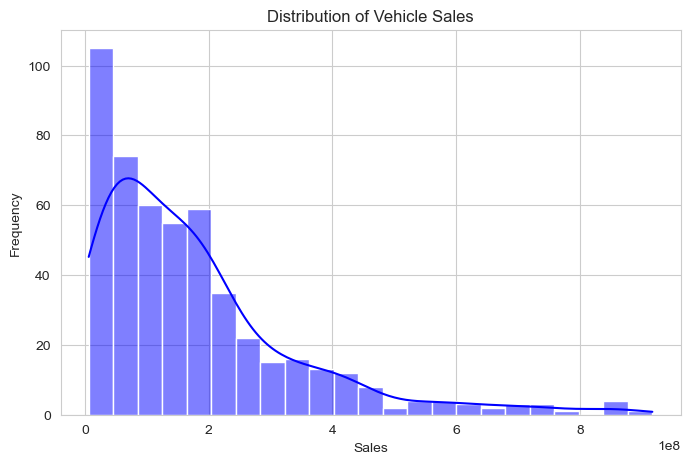

In [5]:
blue = '#4C72B0'
plt.figure(figsize=(8, 5))
sns.histplot(df['sales'], kde=True, color='blue')
plt.title("Distribution of Vehicle Sales")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

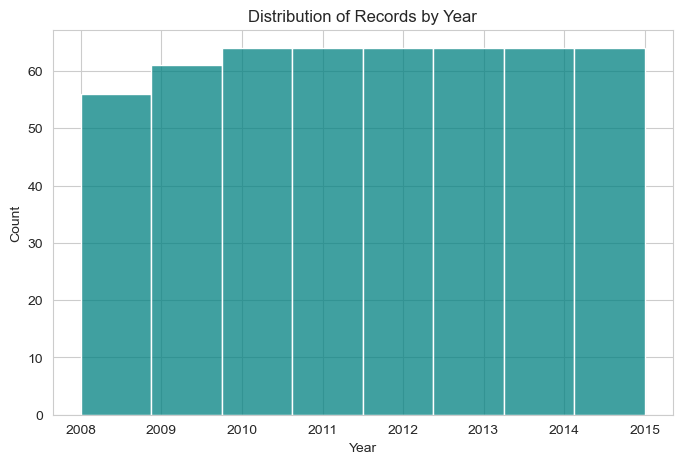

In [6]:
plt.figure(figsize=(8, 5))
sns.histplot(df['year'], bins=8, kde=False, color='teal')
plt.title("Distribution of Records by Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

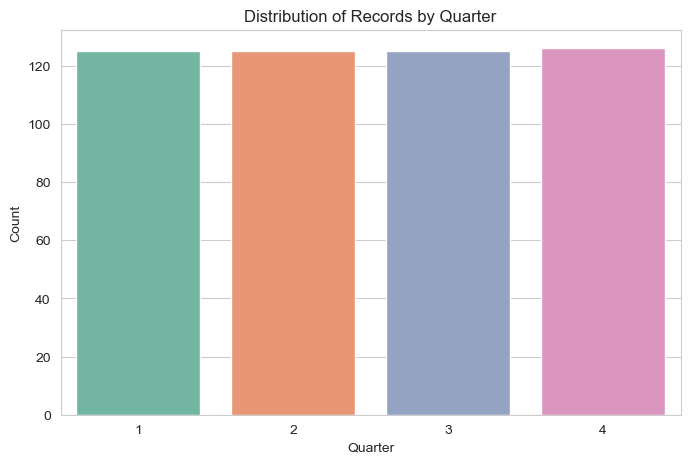

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(
    data=df,
    x='quarter',
    hue='quarter',  
    palette='Set2',
    legend=False
)
plt.title("Distribution of Records by Quarter")
plt.xlabel("Quarter")
plt.ylabel("Count")
plt.show()

In [8]:
df['period'] = df['year'].astype(str) + ' Q' + df['quarter'].astype(str)
df.head()

,year,quarter,county,sales,period
0,2008,1,Adams,231609000,2008 Q1
1,2008,1,Arapahoe,550378000,2008 Q1
2,2008,1,Boulder/Broomfield,176771000,2008 Q1
3,2008,1,Denver,200103000,2008 Q1
4,2008,1,Douglas,93259000,2008 Q1


In [9]:
# Convert year + quarter into a datetime representing the quarter end
df['date'] = pd.PeriodIndex.from_fields(
    year=df['year'],
    quarter=df['quarter'],
    freq='Q'
).to_timestamp()

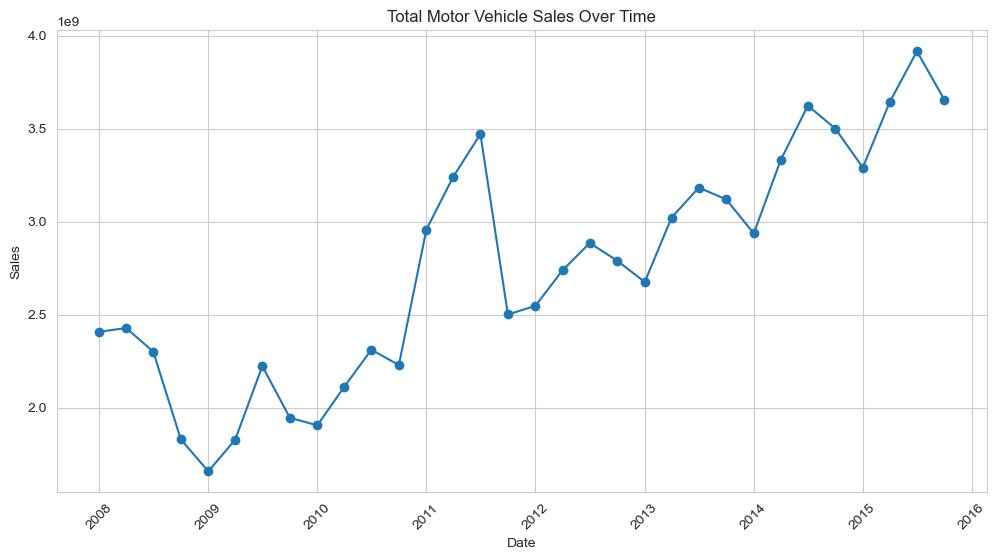

In [10]:
# Aggregate total sales per quarter
quarterly_sales = df.groupby('date')['sales'].sum()

# Plot the trend
plt.figure(figsize=(12, 6))
plt.plot(quarterly_sales.index, quarterly_sales.values, marker='o')
plt.title('Total Motor Vehicle Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

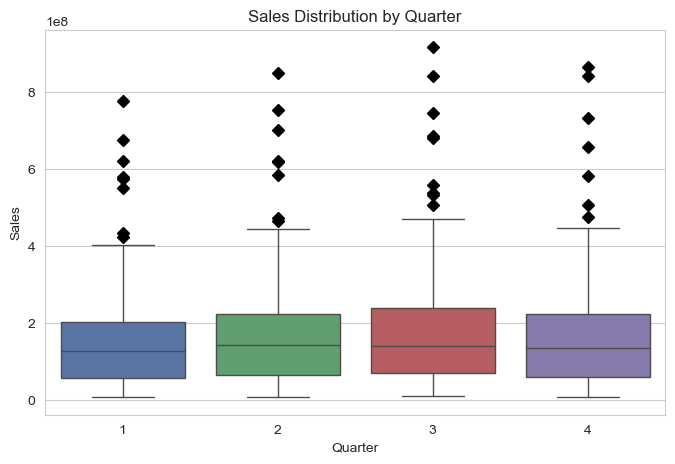

In [11]:
custom_colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B3']  # blue, green, red, purple

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df,
    x='quarter',
    y='sales',
    hue='quarter',
    palette=custom_colors,
    legend=False,
    flierprops=dict(marker='D', markerfacecolor='black', markeredgecolor='black', markersize=6)
)
plt.title('Sales Distribution by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Sales')
plt.show()

In [12]:
# Total sales per county (define the variable)
county_sales = df.groupby('county')['sales'].sum().sort_values(ascending=False)

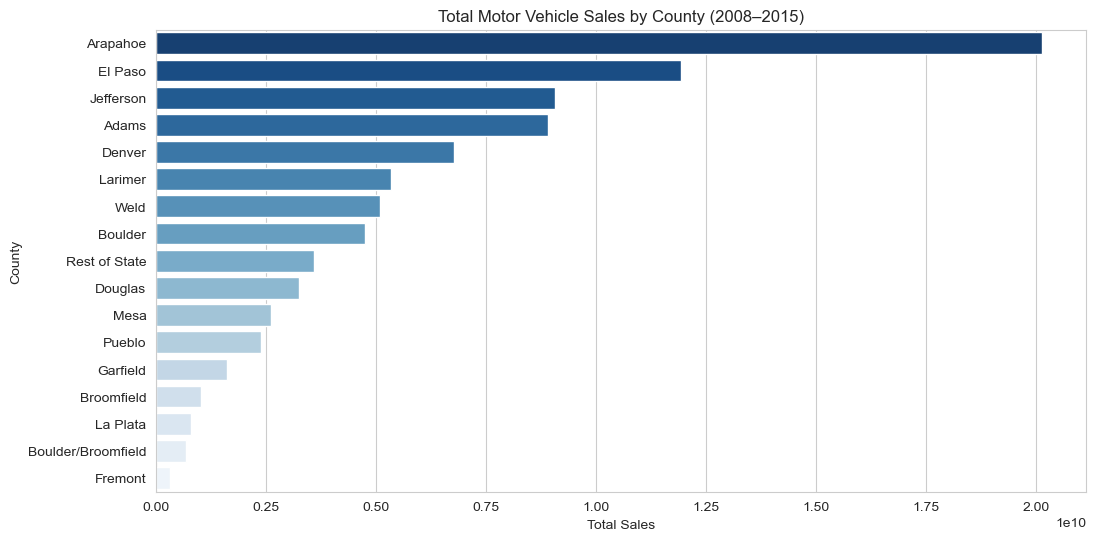

In [13]:
# Total sales per county
plt.figure(figsize=(12, 6))
sns.barplot(
    x=county_sales.values,
    y=county_sales.index,
    hue=county_sales.index,     # assign colors based on county name
    palette='Blues_r',
    legend=False                # hide useless legend
)
plt.title('Total Motor Vehicle Sales by County (2008–2015)')
plt.xlabel('Total Sales')
plt.ylabel('County')
plt.show()

In [14]:
df['year'].min(), df['year'].max(), df['quarter'].unique()

(2008, 2015, array([1, 2, 3, 4]))

In [15]:
# Interactive county sales by year & quarter
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

# make sure the DataFrame 'df' exists
# aggregate and plot function
def plot_sales_by_period(year, quarter, top_n=30):
    # filter and aggregate
    filtered = df[(df['year'] == year) & (df['quarter'] == quarter)]
    if filtered.empty:
        print(f"No data for {year} Q{quarter}")
        return

    county_sales = filtered.groupby('county', as_index=False)['sales'].sum()
    county_sales = county_sales.sort_values('sales', ascending=False).head(top_n)

    palette = sns.color_palette("viridis", len(county_sales))

    plt.figure(figsize=(12, max(4, 0.3*len(county_sales))))  
    sns.barplot(
        x='sales',
        y='county',
        data=county_sales,
        hue='county', 
        palette=palette,
        dodge=False,
        legend=False
    )
    plt.title(f"County Sales for {year} Q{quarter}")
    plt.xlabel("Total Sales")
    plt.ylabel("County")
    plt.tight_layout()
    plt.show()

# create widgets using the dataset min/max values
year_slider = widgets.IntSlider(value=int(df['year'].min()), min=int(df['year'].min()),
                                max=int(df['year'].max()), step=1, description='Year:')
quarter_slider = widgets.IntSlider(value=1, min=1, max=4, step=1, description='Quarter:')

# optional: a small widget to control top N counties shown
topn_widget = widgets.IntSlider(value=20, min=5, max=50, step=1, description='Top N:')

# combine and display
ui = widgets.HBox([year_slider, quarter_slider, topn_widget])
out = widgets.interactive_output(lambda year, quarter, top_n: plot_sales_by_period(year, quarter, top_n),
                                {'year': year_slider, 'quarter': quarter_slider, 'top_n': topn_widget})

display(ui, out)

Output()

# Statistical Analysis

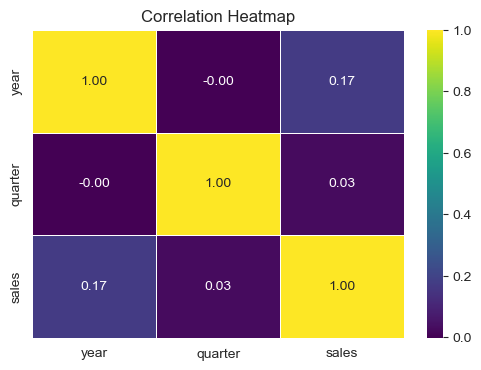

In [16]:
# Select only numeric columns for correlation
numeric_df = df[['year', 'quarter', 'sales']]

# Compute correlation
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='viridis',
    linewidths=0.5,
    fmt='.2f'
)
plt.title('Correlation Heatmap')
plt.show()

The correlation analysis shows that sales have a weak direct correlation with 
year and quarter at the individual record level. This indicates that simple 
correlation alone does not capture underlying trends and seasonal effects, 
which require time-series analysis.

In [17]:
# Aggregate total sales per quarter (across all counties)
quarterly_sales = df.groupby('date')['sales'].sum().sort_index()

quarterly_sales.head()

date
2008-01-01    2407552000
2008-04-01    2427936000
2008-07-01    2300541000
2008-10-01    1829532000
2009-01-01    1657155000
Name: sales, dtype: int64

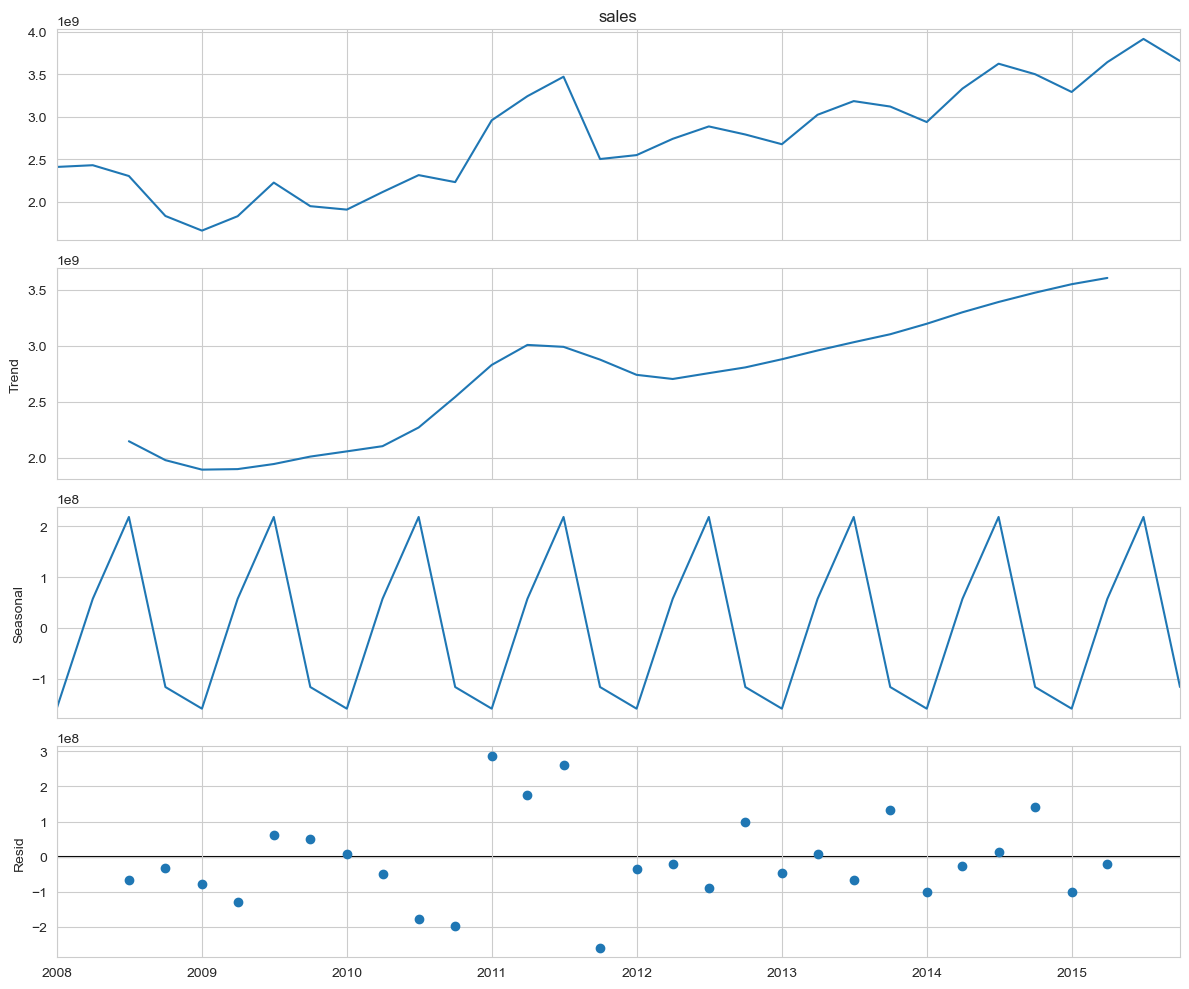

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose with a quarterly period = 4 (4 quarters per year)
decomposition = seasonal_decompose(quarterly_sales, model='additive', period=4)

# Plot the full decomposition
plt.rcParams["figure.figsize"] = (12, 10)
decomposition.plot()
plt.show()

Seasonal decomposition reveals a clear long-term upward trend in motor vehicle 
sales along with a strong quarterly seasonal pattern. Sales typically peak in 
the third quarter and decline in the first quarter, confirming consistent 
seasonality across years.

# Predictive Modeling

In [19]:
# Quarterly total sales time series
quarterly_sales = df.groupby('date')['sales'].sum().sort_index()

quarterly_sales.tail()

date
2014-10-01    3500455000
2015-01-01    3291273000
2015-04-01    3642834000
2015-07-01    3916440000
2015-10-01    3656185000
Name: sales, dtype: int64

In [20]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model = ARIMA(quarterly_sales, order=(1, 1, 1))
model_fit = model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                   32
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -649.942
Date:                Fri, 26 Dec 2025   AIC                           1305.885
Time:                        17:37:45   BIC                           1310.187
Sample:                    01-01-2008   HQIC                          1307.287
                         - 10-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6056      0.732      0.827      0.408      -0.829       2.041
ma.L1         -0.7056      0.623     -1.133      0.257      -1.926       0.515
sigma2       9.87e+16        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.84
Prob(Q):                              0.99   Prob(JB):                         0.03
Heteroskedasticity (H):               1.11   Skew:                            -0.74
Prob(H) (two-sided):                  0.88   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.35e+52. Standard errors may be unstable.
"""

In [21]:
# Forecast next 8 quarters
forecast_steps = 8
forecast = model_fit.forecast(steps=forecast_steps)

forecast

2016-01-01    3.646258e+09
2016-04-01    3.640246e+09
2016-07-01    3.636605e+09
2016-10-01    3.634401e+09
2017-01-01    3.633065e+09
2017-04-01    3.632257e+09
2017-07-01    3.631767e+09
2017-10-01    3.631471e+09
Freq: QS-OCT, Name: predicted_mean, dtype: float64

In [22]:
# Create future dates (quarterly)
future_dates = pd.date_range(
    start=quarterly_sales.index[-1],
    periods=forecast_steps + 1,
    freq='QE'
)[1:]

future_dates

DatetimeIndex(['2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31',
               '2017-03-31', '2017-06-30', '2017-09-30', '2017-12-31'],
              dtype='datetime64[ns]', freq='QE-DEC')

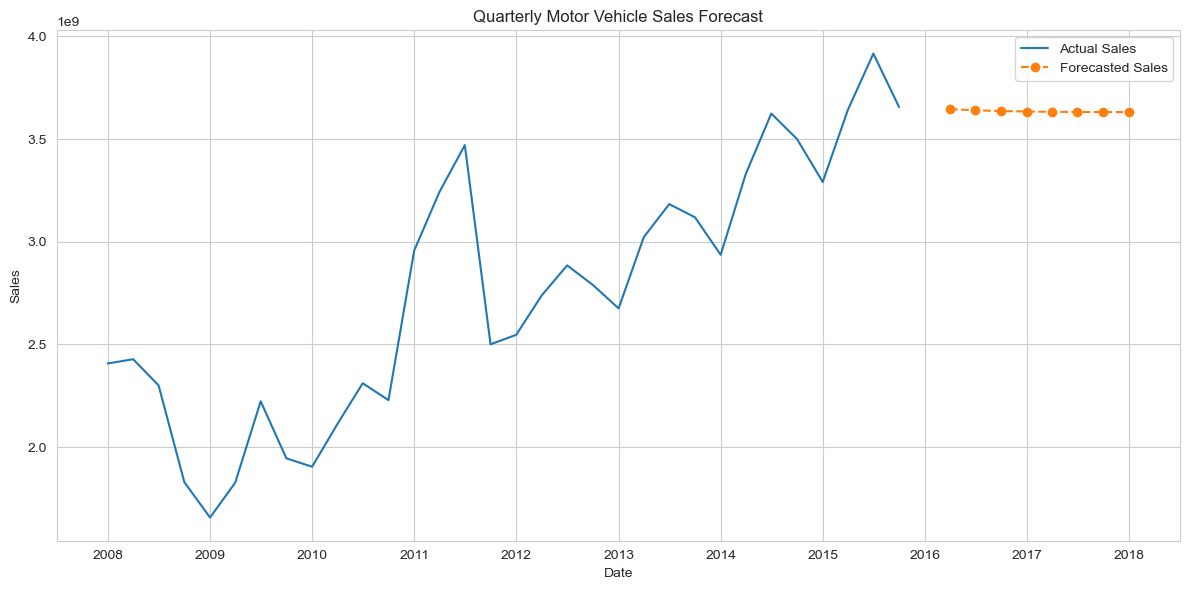

In [23]:
plt.figure(figsize=(12, 6))

# Actual sales
plt.plot(quarterly_sales.index, quarterly_sales.values, label='Actual Sales')

# Forecasted sales
plt.plot(future_dates, forecast, label='Forecasted Sales', linestyle='--', marker='o')

plt.title('Quarterly Motor Vehicle Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

The ARIMA(1,1,1) model was used to forecast quarterly motor vehicle sales.
The results indicate relatively stable sales levels in the near term, suggesting
a continuation of recent trends without significant upward or downward shifts.

## Model Evaluation (MSE)

In [24]:
from sklearn.metrics import mean_squared_error

In [25]:
ts = quarterly_sales.copy()

train = ts[:-4]   # all except last 4 quarters
test = ts[-4:]    # last 4 quarters

train, test

(date
 2008-01-01    2407552000
 2008-04-01    2427936000
 2008-07-01    2300541000
 2008-10-01    1829532000
 2009-01-01    1657155000
 2009-04-01    1826950000
 2009-07-01    2223123000
 2009-10-01    1945272000
 2010-01-01    1904579000
 2010-04-01    2111542000
 2010-07-01    2311231000
 2010-10-01    2228736000
 2011-01-01    2957148000
 2011-04-01    3241654000
 2011-07-01    3470846000
 2011-10-01    2500793000
 2012-01-01    2547108000
 2012-04-01    2738843000
 2012-07-01    2885037000
 2012-10-01    2789888000
 2013-01-01    2675387000
 2013-04-01    3022493000
 2013-07-01    3183370000
 2013-10-01    3119365000
 2014-01-01    2936644000
 2014-04-01    3331042000
 2014-07-01    3624346000
 2014-10-01    3500455000
 Name: sales, dtype: int64,
 date
 2015-01-01    3291273000
 2015-04-01    3642834000
 2015-07-01    3916440000
 2015-10-01    3656185000
 Name: sales, dtype: int64)

In [26]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA on training data only
eval_model = ARIMA(train, order=(1, 1, 1))
eval_model_fit = eval_model.fit()

In [27]:
# Forecast for the test period (last 4 quarters)
test_forecast = eval_model_fit.forecast(steps=len(test))

test_forecast

2015-01-01    3.475026e+09
2015-04-01    3.459167e+09
2015-07-01    3.449276e+09
2015-10-01    3.443108e+09
Freq: QS-OCT, Name: predicted_mean, dtype: float64

In [28]:
mse = mean_squared_error(test, test_forecast)
mse

8.278566665212214e+16

**Model Evaluation (Mean Squared Error):**  
The ARIMA(1,1,1) model was evaluated using a time-based train–test split, 
with the final four quarters used as the test set.  
The resulting Mean Squared Error (MSE) was **8.28 × 10¹⁶**, which is reasonable 
given the large scale and variability of quarterly motor vehicle sales data.  
This indicates that the model is suitable for capturing overall trends and 
short-term forecasting patterns rather than precise point predictions.

## Conclusion & Key Insights

This project analyzed motor vehicle sales data across counties in Colorado from 2008 to 2015
to understand sales trends, seasonal behavior, and future sales patterns.

Exploratory data analysis revealed a clear long-term upward trend in sales following the
2008–2009 downturn, along with significant variation across counties. Seasonal analysis
showed consistent quarterly patterns, with sales typically peaking in the third quarter
and declining in the first quarter each year.

Time-series forecasting using an ARIMA(1,1,1) model suggested relatively stable sales levels
in the near term, indicating a continuation of recent trends rather than extreme growth or
decline. Model performance was evaluated using Mean Squared Error (MSE), which was found to be
reasonable given the scale and volatility of the data.

Overall, the analysis demonstrates how historical sales data can be used to uncover trends,
seasonality, and short-term forecasts. Future improvements could include incorporating
additional economic variables or using seasonal models (SARIMA) to further enhance forecast
accuracy.